In [26]:
import numpy as np
import xarray as xr
from pathlib import Path
from netCDF4 import Dataset
import argparse
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
import glob
import os
from xeofs.xarray import EOF


In [3]:

main_dir = Path.cwd().parent # Main directory path of project repository - all filepaths are relative to this

# File path directories
DIR_external = 'data/external/'

# DATASET FILEPATHS
# Basal melt observations from Paolo 2023
DIR_basalMeltObs = 'data/external/Paolo2023/'
# Ocean model output - E3SM (SORRMv2.1.ISMF), data received from Darin Comeau / Matt Hoffman at LANL
DIR_SORRMv21 = 'data/external/SORRMv2.1.ISMF/regridded_output/'

# DATA FILENAMES
FILE_MeltDraftObs = 'ANT_G1920V01_IceShelfMeltDraft.nc'
FILE_SORRMv21 = 'Regridded_SORRMv2.1.ISMF.FULL.nc'
FILE_SORRMv21_DETRENDED = 'SORRMv21_detrended.nc'
FILE_iceShelvesShape = 'iceShelves.geojson'

# INTERIM GENERATED FILEPATHS
DIR_basalMeltObs_Interim = 'data/interim/Paolo2023/iceShelves_dedraft/iceShelfRegions/'
DIR_SORRMv21_Interim = 'data/interim/SORRMv2.1.ISMF/iceShelves_dedraft/iceShelfRegions/'


In [29]:
obs23_clean = xr.open_dataset(main_dir / DIR_basalMeltObs_Interim / "obs23_clean.nc")
sorrmv21_clean = xr.open_dataset(main_dir / DIR_SORRMv21_Interim / "sorrmv21_clean.nc")

In [30]:
fl = sorrmv21_clean.__xarray_dataarray_variable__

In [37]:
fl['Time'] = range(12000)

In [40]:
model = EOF(obs23_clean.melt)

ValueError: Invalid data: contains individual NaNs

In [12]:
sorrmv21_clean = xr.open_dataset(main_dir / DIR_SORRMv21_Interim / "sorrmv21_clean.nc", chunks={"Time":300})

In [56]:
if 'time' in ds.dims:
    tdim = 'time'
elif 'Time' in ds.dims:
    tdim = 'Time'

In [5]:
obs23_ts = obs23_clean.sum(["x","y"])
# sorrmv21_ts = sorrmv21_clean.sum(["x","y"])

In [58]:
dsmonth = ds.groupby("Time.month")

In [59]:
dsmonth

DatasetGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [ ]:


# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize 
flux_month = sorrmv21_clean.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

In [14]:
sorrmv21_ts = sorrmv21_clean.__xarray_dataarray_variable__.sum(["x","y"]).compute()

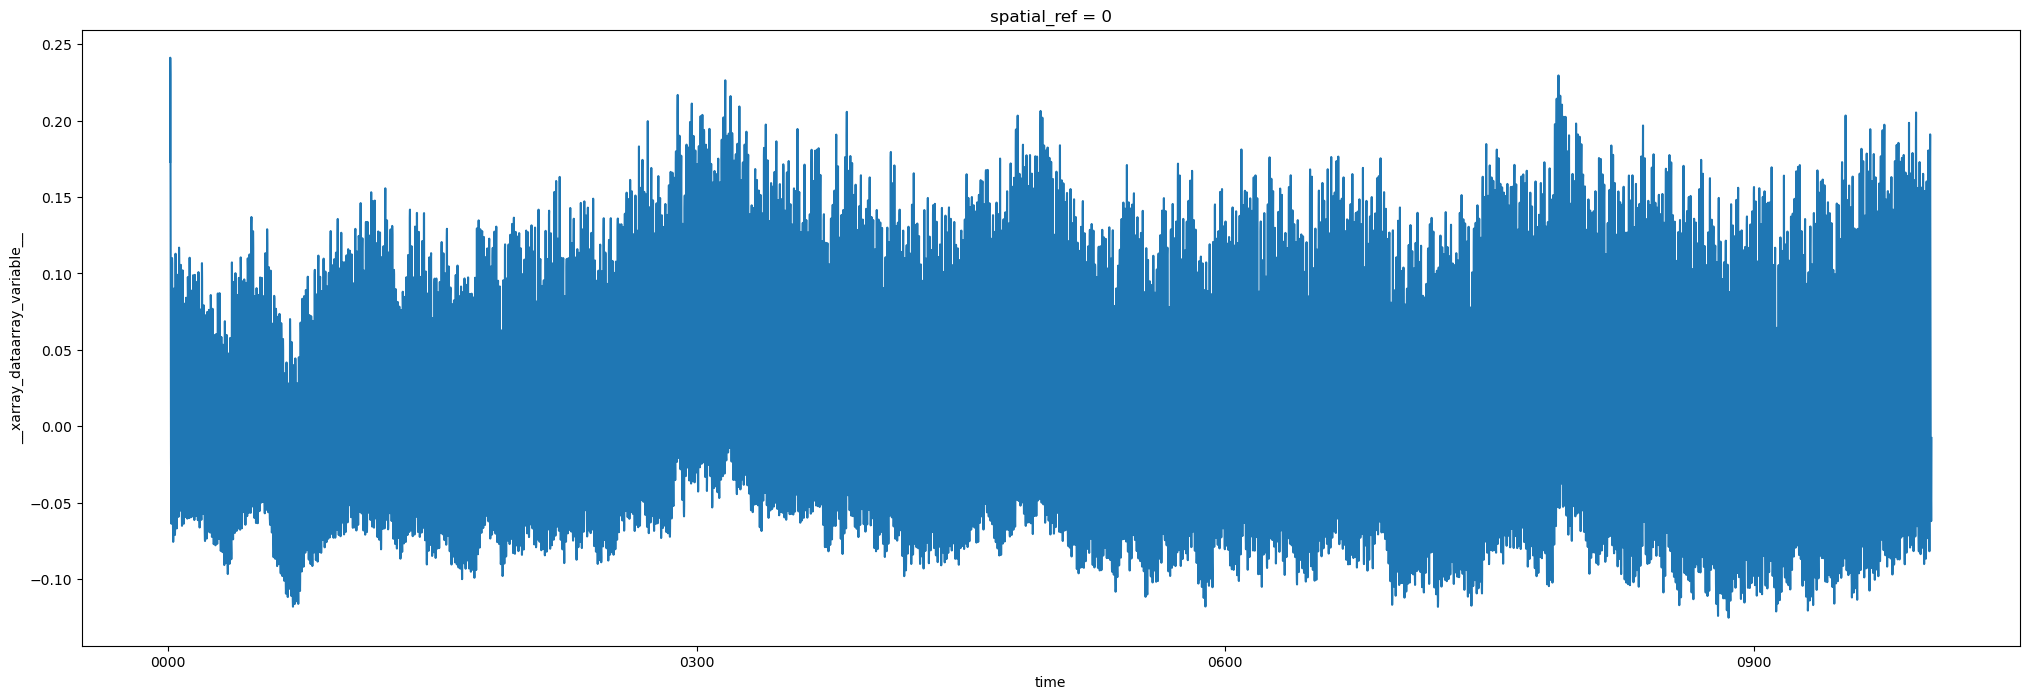

In [64]:
plt.figure(figsize=(25,8))
sorrmv21_ts.plot()

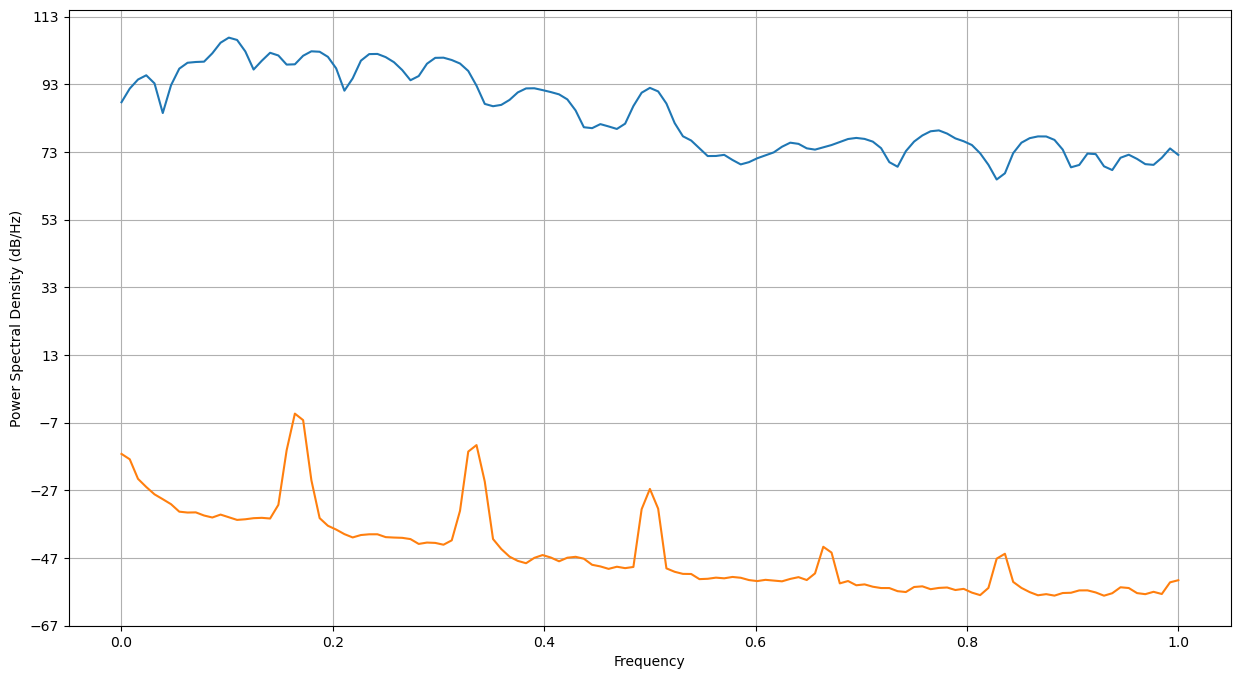

In [61]:
plt.figure(figsize=(15,8))
plt.psd(obs23_ts.melt);
plt.psd(sorrmv21_ts);

In [65]:
DIR_SORRMv21 = Path()
main_dir / DIR_SORRMv21 / FILE_SORRMv21_DETRENDED

PosixPath('/Users/smurugan9/research/aislens/aislens_emulation/data/external/SORRMv2.1.ISMF/regridded_output/SORRMv21_detrended.nc')

In [ ]:
ctrlRegional = xr.open_dataset(ctrl+regionalStats)
exp01Regional = xr.open_dataset(exp01+regionalStats)

#ctrlglobal = xr.open_dataset(ctrl+globalStats)
exp01global = xr.open_dataset(exp01+globalStats)

In [ ]:
ds = xr.open_dataset(dir1)
ds2 = xr.open_dataset(dir2)
ds3 = xr.open_dataset(dir3)
ds.deltat[:50].plot(label='obs23MALI (50 of 325 timesteps)')
ds2.deltat.plot(label='origMALI')
tmpds.deltat.plot(label='obs23MALI (Modified timestep)')
#ds3.deltat[:50].plot(label='obs23-1101-MALI')
plt.title('ismip6/hist04 runs')
plt.legend()

In [ ]:
#ds.surfaceSpeedMax[:50].plot(label='obs23MALI (100 of 325 timesteps)')
ds2.surfaceSpeedMax.plot(label='origMALI')
tmpds.surfaceSpeedMax.plot(label='obs23MALI (Modified timestep)')
#ds3.deltat[:50].plot(label='obs23-1101-MALI')
plt.title('ismip6/hist04 runs')
plt.legend()

In [ ]:
MELTDRAFT_OBS = xr.open_dataset(main_dir / DIR_basalMeltObs / FILE_MeltDraftObs, chunks={'x':729, 'y':729})

In [ ]:
MELTDRAFT_OBS.rio.write_crs("epsg:3031",inplace=True);


In [ ]:
h = MELTDRAFT_OBS.draft
if 'time' in h.dims:
    tdim = 'time'
elif 'Time' in h.dims:
    tdim = 'Time'

h_mean = h.mean(tdim)

IMBIEregions = range(6,33)
iceShelfRegions = range(33,133)

In [ ]:
mlt = MELTDRAFT_OBS.melt.rio.clip(icems.loc[[34],'geometry'].apply(mapping),icems.crs,drop=False)
mlt_mean = mlt.mean(tdim)
# Dedraft: Linear Regression with SSH over chosen basin
print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
mlt_rgrs = xr_linregress(h, mlt_mean, dim=tdim) # h = independent variable

In [ ]:
mlt_prd = mlt_rgrs.slope*h_mean + mlt_rgrs.intercept

In [ ]:
icems.name.values

In [ ]:
DIR_external = 'data/external/'
DIR_interim = 'data/interim/'

# DATASET FILEPATHS
# Ocean model output - E3SM (SORRMv2.1.ISMF), data received from Darin Comeau / Matt Hoffman at LANL
DIR_SORRMv21 = 'data/external/SORRMv2.1.ISMF/regridded_output/'
FILE_SORRMv21 = 'Regridded_SORRMv2.1.ISMF.FULL.nc'
FILE_SORRMv21_DETRENDED_TS = 'SORRMv21_detrended_ts.nc'

ds = xr.open_dataset(main_dir / DIR_SORRMv21 / FILE_SORRMv21_DETRENDED_TS)


In [ ]:
ds["flux_sum"] = ds.__xarray_dataarray_variable__

In [ ]:
plt.figure(figsize=(25,8))
ds.__xarray_dataarray_variable__.plot()

In [ ]:
ds.__xarray_dataarray_variable__.rename("flux_xy_sum")

In [ ]:
ds